<!-- Sales and Operations Planning -->

In [4]:
%pip install pandas
%pip install statsmodels
%pip install scikit-learn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   --- ------------------------------------ 0.8/9.6 MB 1.3 MB/s eta 0:00:07
   ---- ----------------------------------- 1.0/9.6 MB 1.3 MB/s eta 0:00:07
   ------ --------------------------------- 1.6/9.6 MB 1.6 MB/s eta 0:00:05
   ------- -------------------------------- 1.8/9.6 MB 1.7 MB/s eta 0:00:05
   --------- ------------------------------ 2.4/9.6 MB 1.7 MB/s eta 0:00:05
   ------------- -------------------------- 3.1/9.6 MB 2.0 MB/s eta 0:00:04
   -------------- ------------------------- 3.4/9.6 MB 1.8 MB/s eta 0:00:04
   --------------- ------------------------ 3.7/9.6 MB 1.9 M

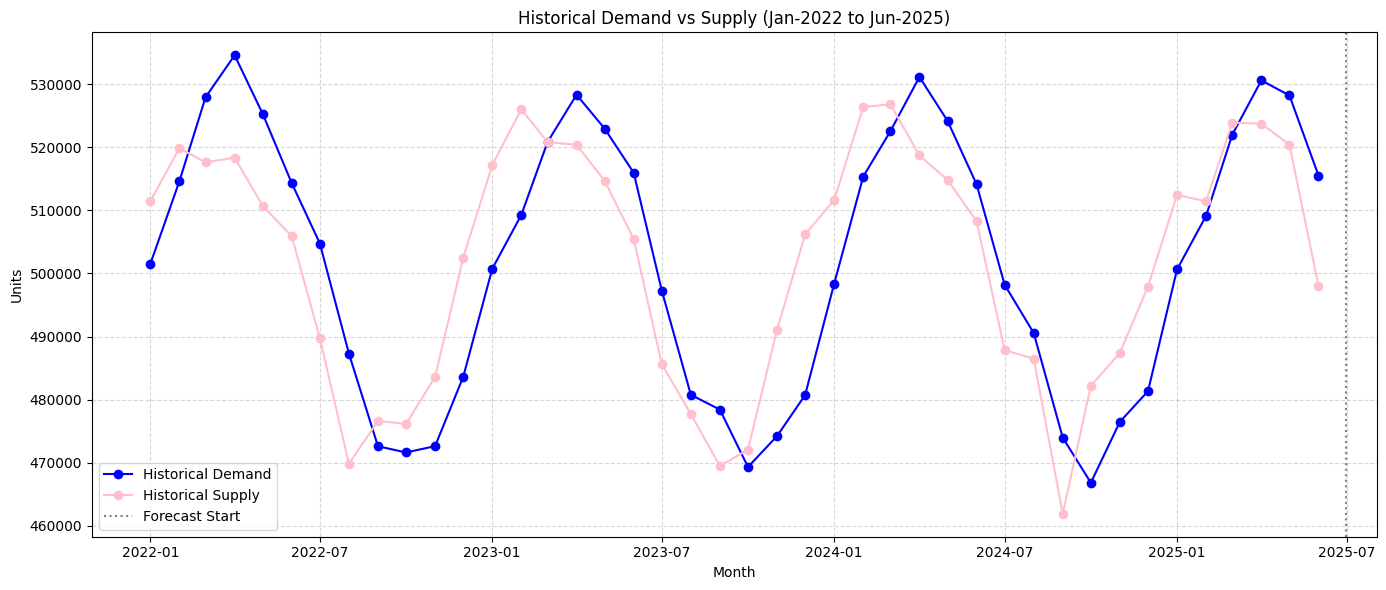

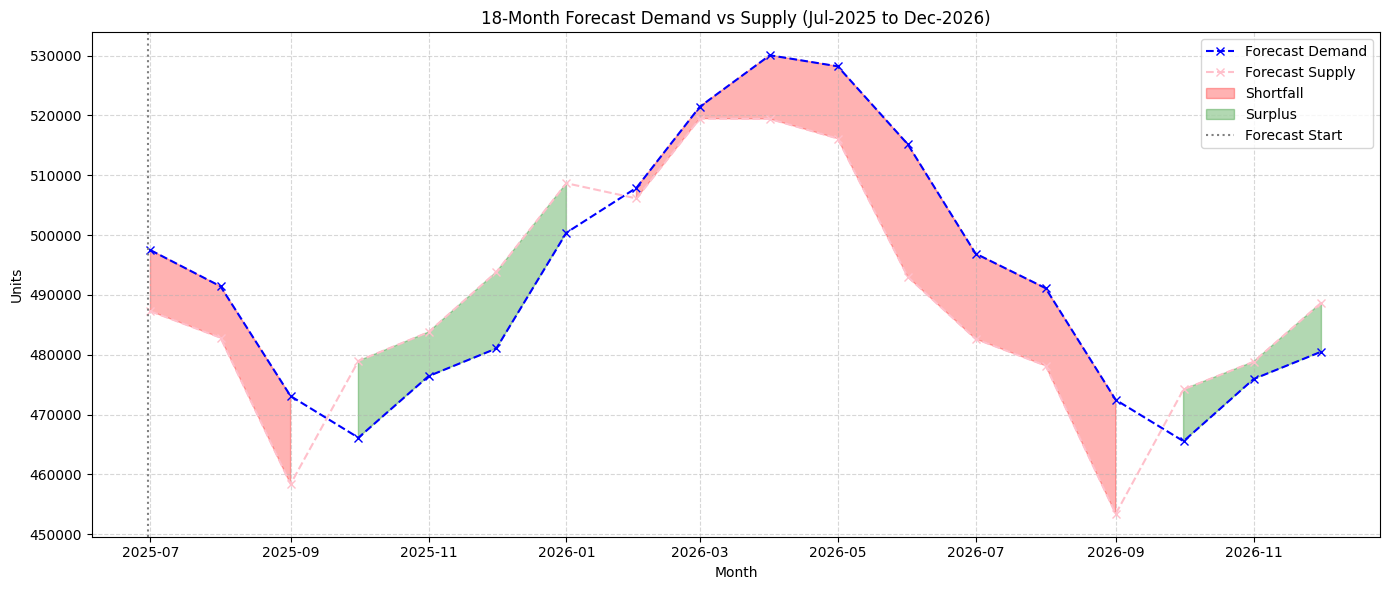

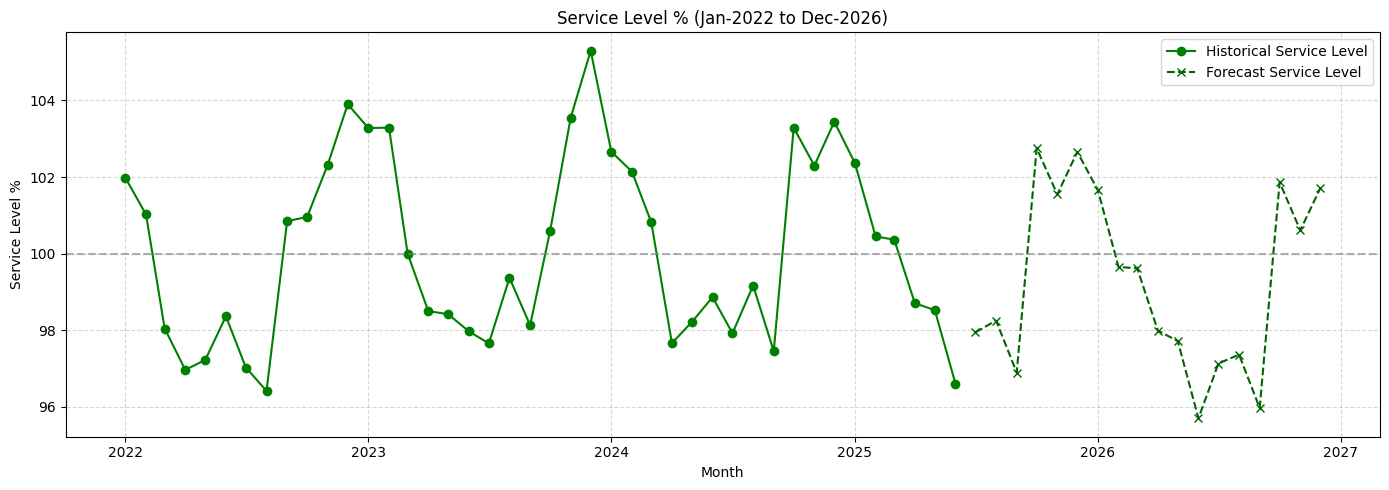

{'demand_mape': 2.76, 'demand_rmse': 14398, 'demand_r2': -0.871, 'supply_mape': 1.88, 'supply_rmse': 12901, 'supply_r2': -1.027}


In [5]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# 1. Simulate historical data
# -------------------------------
np.random.seed(42)
months = pd.date_range(start="2022-01-01", end="2025-06-30", freq='MS')

# Simulate demand
demand = np.round(
    500000
    + 30000*np.sin(np.arange(len(months))*2*np.pi/12)  # yearly seasonality
    + np.random.normal(0, 3000, len(months)), 0
)

# Simulate supply (phase-shifted & noisier)
supply = np.round(
    500000
    + 25000*np.sin((np.arange(len(months))*2*np.pi/12) + 0.5)
    + np.random.normal(0, 5000, len(months)), 0
)

# Create dataframe
data = pd.DataFrame({
    "Month": months,
    "Demand": demand,
    "Supply": supply
})

# Status column
def status(d, s):
    if abs(d - s) <= 2000:
        return "Met"
    elif s > d:
        return "Exceeded"
    else:
        return "Not Met"

data["Status"] = [status(d, s) for d, s in zip(data["Demand"], data["Supply"])]
data.set_index("Month", inplace=True)

# Availability gap & service level
data['Availability_Gap'] = data['Demand'] - data['Supply']
data['Service_Level_%'] = (data['Supply'] / data['Demand']) * 100

# -------------------------------
# 2. Train/test split for evaluation
# -------------------------------
train_end = '2024-12-01'
train = data[:train_end]
test = data['2025-01-01':]

order = (1,1,1)
seasonal = (1,1,1,12)

# Fit SARIMA models
d_fit = SARIMAX(train['Demand'], order=order, seasonal_order=seasonal,
                enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
s_fit = SARIMAX(train['Supply'], order=order, seasonal_order=seasonal,
                enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

# Forecast test period (Jan-Jun 2025) for accuracy check
d_pred_test = d_fit.forecast(steps=len(test))
s_pred_test = s_fit.forecast(steps=len(test))

# Accuracy metrics
def calc_metrics(actual, pred):
    return (
        mean_absolute_percentage_error(actual, pred) * 100,
        np.sqrt(mean_squared_error(actual, pred)),
        r2_score(actual, pred)
    )

d_mape, d_rmse, d_r2 = calc_metrics(test['Demand'], d_pred_test)
s_mape, s_rmse, s_r2 = calc_metrics(test['Supply'], s_pred_test)

# -------------------------------
# 3. Final fit & 18-month forecast (Jul-2025 to Dec-2026)
# -------------------------------
train_full = data[:'2025-06-01']

d_fit_full = SARIMAX(train_full['Demand'], order=order, seasonal_order=seasonal,
                     enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
s_fit_full = SARIMAX(train_full['Supply'], order=order, seasonal_order=seasonal,
                     enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)

forecast_steps = 18
future_months = pd.date_range(start="2025-07-01", periods=forecast_steps, freq="MS")

d_forecast = d_fit_full.forecast(steps=forecast_steps)
s_forecast = s_fit_full.forecast(steps=forecast_steps)

forecast_df = pd.DataFrame({
    "Demand_Forecast": np.round(d_forecast, 0).astype(int),
    "Supply_Forecast": np.round(s_forecast, 0).astype(int),
}, index=future_months)

forecast_df["Availability_Gap"] = forecast_df["Demand_Forecast"] - forecast_df["Supply_Forecast"]
forecast_df["Service_Level_%"] = (forecast_df["Supply_Forecast"] / forecast_df["Demand_Forecast"]) * 100

# -------------------------------
# 4. Plot historical + forecast
# -------------------------------
# Chart 1 - Historical Demand v Supply
plt.figure(figsize=(14,6))
plt.plot(data.index, data['Demand'], label='Historical Demand', color='blue', marker='o')
plt.plot(data.index, data['Supply'], label='Historical Supply', color='pink', marker='o')
# plt.plot(forecast_df.index, forecast_df['Demand_Forecast'], label='Forecast Demand', linestyle='--', color='blue', marker='x')
# plt.plot(forecast_df.index, forecast_df['Supply_Forecast'], label='Forecast Supply', linestyle='--', color='pink', marker='x')
plt.axvline(pd.to_datetime("2025-06-30"), color='gray', linestyle=':', label='Forecast Start')
plt.title('Historical Demand vs Supply (Jan-2022 to Jun-2025)')
plt.xlabel('Month')
plt.ylabel('Units')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Chart 2 - 18-Month Forecast
plt.figure(figsize=(14,6))
# plt.plot(data.index, data['Demand'], label='Historical Demand', color='blue', marker='o')
# plt.plot(data.index, data['Supply'], label='Historical Supply', color='pink', marker='o')
plt.plot(forecast_df.index, forecast_df['Demand_Forecast'], label='Forecast Demand', linestyle='--', color='blue', marker='x')
plt.plot(forecast_df.index, forecast_df['Supply_Forecast'], label='Forecast Supply', linestyle='--', color='pink', marker='x')
# Shading shortfalls and surpluses
plt.fill_between(forecast_df.index,
                 forecast_df['Demand_Forecast'], forecast_df['Supply_Forecast'],
                 where=(forecast_df['Supply_Forecast'] < forecast_df['Demand_Forecast']),
                 color='red', alpha=0.3, label='Shortfall')
plt.fill_between(forecast_df.index,
                 forecast_df['Demand_Forecast'], forecast_df['Supply_Forecast'],
                 where=(forecast_df['Supply_Forecast'] > forecast_df['Demand_Forecast']),
                 color='green', alpha=0.3, label='Surplus')
plt.axvline(pd.to_datetime("2025-06-30"), color='gray', linestyle=':', label='Forecast Start')
plt.title('18-Month Forecast Demand vs Supply (Jul-2025 to Dec-2026)')
plt.xlabel('Month')
plt.ylabel('Units')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()





# Service Level Plot
plt.figure(figsize=(14,5))
plt.plot(data.index, data['Service_Level_%'], label='Historical Service Level', color='green', marker='o')
plt.plot(forecast_df.index, forecast_df['Service_Level_%'], label='Forecast Service Level', linestyle='--', color='darkgreen', marker='x')
plt.axhline(y=100, color='gray', linestyle='--', alpha=0.6)
plt.title('Service Level % (Jan-2022 to Dec-2026)')
plt.ylabel('Service Level %')
plt.xlabel('Month')
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# -------------------------------
# 5. Save forecast to CSV
# -------------------------------
forecast_df.to_csv("Data/demand_supply_forecast_Jul2025_Dec2026.csv", index_label="Month")

# -------------------------------
# 6. Output metrics
# -------------------------------
results = {
    'demand_mape': round(d_mape, 2),
    'demand_rmse': int(round(d_rmse)),
    'demand_r2': round(d_r2, 3),
    'supply_mape': round(s_mape, 2),
    'supply_rmse': int(round(s_rmse)),
    'supply_r2': round(s_r2, 3)
}
print(results)
